In [11]:
import pandas as pd
import numpy as np

happiness = pd.read_excel('../data/happiness/happiness_2022.xls')
hdi = pd.read_excel('../data/happiness/hdi.xlsx')

In [12]:
print(hdi.columns)
hdi = hdi[hdi['indicatorCode'] == 'hdi']
hdi_df = hdi[['countryIsoCode', 'value', 'year']]
hdi_df = hdi_df.rename(columns={'countryIsoCode': 'ISO_A3', 'value': 'HDI', 'year': 'Year'})

print(hdi_df.head())

Index(['countryIsoCode', 'country', 'indexCode', 'index', 'dimension',
       'indicatorCode', 'indicator', 'year', 'value', 'note'],
      dtype='object')
   ISO_A3    HDI  Year
66    AFG  0.284  1990
67    AFG  0.292  1991
68    AFG  0.299  1992
69    AFG  0.307  1993
70    AFG  0.300  1994


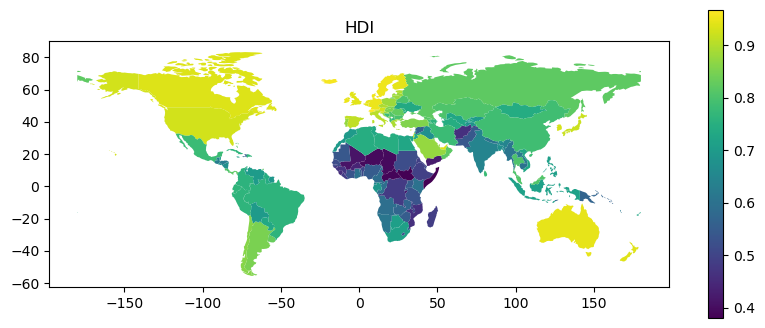

In [13]:
from GeoPlotter import GeoPlotter
gp = GeoPlotter(hdi_df)
gp.plot('HDI', '2022')

/home/jcdutoit/Documents/ACME/Vol3/Vol3FallProj/Joseph_workspace/DataPipeline.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ISO_A3'] = df['Country'].apply(get_country_code)


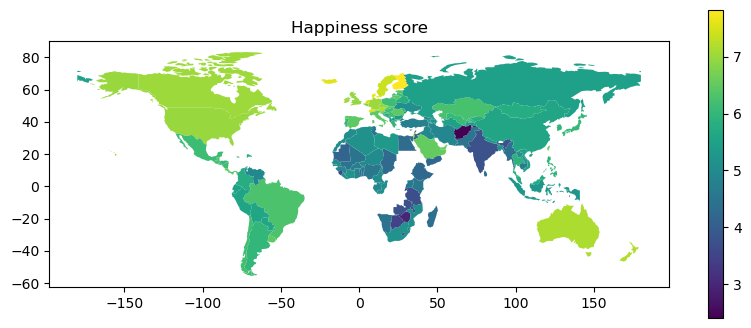

In [14]:
from DataPipeline import DataPipeline
hap_df = happiness[['Country', 'Happiness score']]

dp = DataPipeline(df=hap_df)
dp.clean(['name_change'])
gp2 = GeoPlotter(hap_df)
gp2.plot('Happiness score')


    ISO_A3    HDI
98     AFG  0.462
255    AGO  0.591
412    ALB  0.789
568    AND  0.884
724    ARE  0.937
       Country  Happiness score ISO_A3
0      Finland           7.8210    FIN
1      Denmark           7.6362    DNK
2      Iceland           7.5575    ISL
3  Switzerland           7.5116    CHE
4  Netherlands           7.4149    NLD
       Country  Happiness score ISO_A3    HDI
0      Finland           7.8210    FIN  0.942
1      Denmark           7.6362    DNK  0.952
2      Iceland           7.5575    ISL  0.959
3  Switzerland           7.5116    CHE  0.967
4  Netherlands           7.4149    NLD  0.946


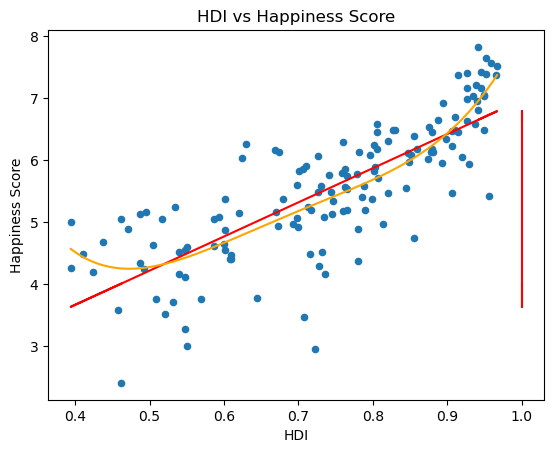

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

hdi_trunc = hdi_df[hdi_df['Year'] == 2022]
hdi_trunc = hdi_trunc.drop(columns=['Year'])
print(hdi_trunc.head())
print(hap_df.head())
hdi_trunc = hdi_trunc[hdi_trunc['ISO_A3'].isin(hap_df['ISO_A3'])]
merged = pd.merge(hap_df, hdi_trunc, on='ISO_A3')
print(merged.head())

x = merged['HDI']
y = merged['Happiness score']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()

model2 = np.polyfit(merged['HDI'], merged['Happiness score'], 3)

merged.plot.scatter(x='HDI', y='Happiness score')
xs = np.linspace(hdi_trunc['HDI'].min(), hdi_trunc['HDI'].max(), 1000)
plt.plot(x, model.predict(x), color='red')
plt.plot(xs, np.polyval(model2, xs), color='orange')
plt.xlabel('HDI')
plt.ylabel('Happiness Score')
plt.title('HDI vs Happiness Score')
plt.show()
